In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex1 import *

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/kaggle/input/augmented-alzheimer-mri-dataset',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/kaggle/input/augmented-alzheimer-mri-dataset',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 40384 files belonging to 2 classes.
Found 40384 files belonging to 2 classes.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [3]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [4]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
)

Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - binary_accuracy: 0.8703 - loss: 0.2703 - val_binary_accuracy: 0.9531 - val_loss: 0.1160
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - binary_accuracy: 0.9885 - loss: 0.0985 - val_binary_accuracy: 0.9996 - val_loss: 0.0624
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - binary_accuracy: 0.9956 - loss: 0.0619 - val_binary_accuracy: 0.9998 - val_loss: 0.0409
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - binary_accuracy: 0.9985 - loss: 0.0402 - val_binary_accuracy: 0.9989 - val_loss: 0.0301
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - binary_accuracy: 0.9975 - loss: 0.0312 - val_binary_accuracy: 1.0000 - val_loss: 0.0204
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - binary_accuracy: 0.9999 - loss: 0.0192 - val_binary_accuracy: 1.0000 - val_loss: 0.0152
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - binary_accuracy: 1.0000 - loss: 0.0139 - val_binary_accuracy: 1.0000 - 

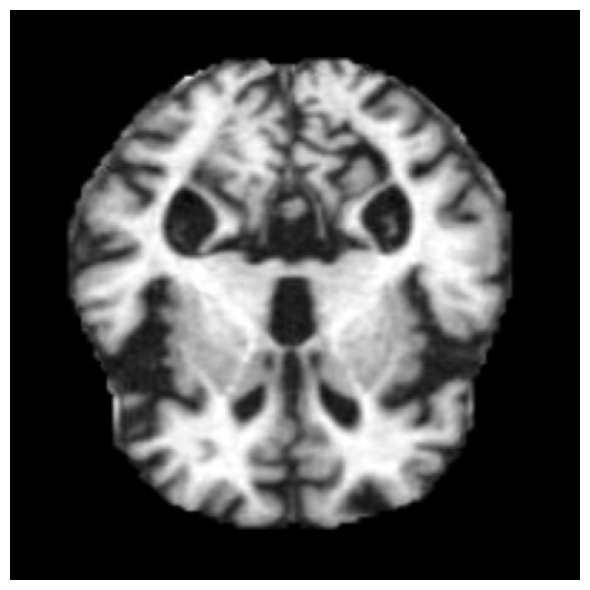

In [5]:
image_path = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/001ef5a6-893b-4ede-9cf8-60b7fb94a541.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show();

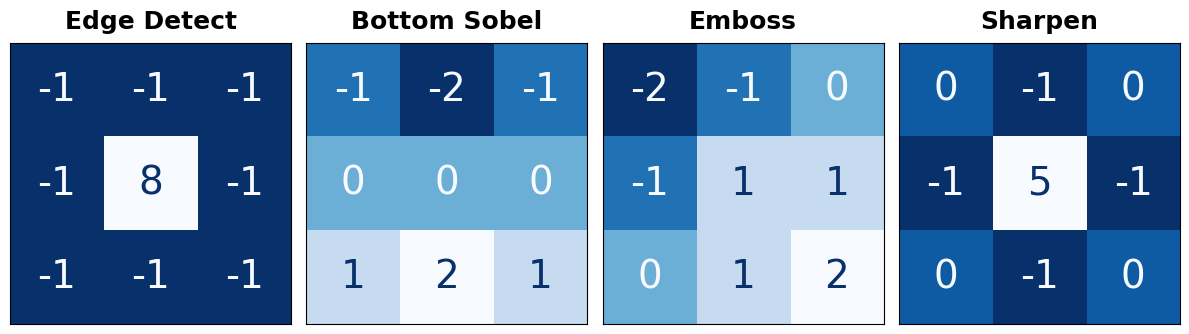

In [6]:
import learntools.computer_vision.visiontools as visiontools
from learntools.computer_vision.visiontools import edge, bottom_sobel, emboss, sharpen

kernels = [edge, bottom_sobel, emboss, sharpen]
names = ["Edge Detect", "Bottom Sobel", "Emboss", "Sharpen"]

plt.figure(figsize=(12, 12))
for i, (kernel, name) in enumerate(zip(kernels, names)):
    plt.subplot(1, 4, i+1)
    visiontools.show_kernel(kernel)
    plt.title(name)
plt.tight_layout()

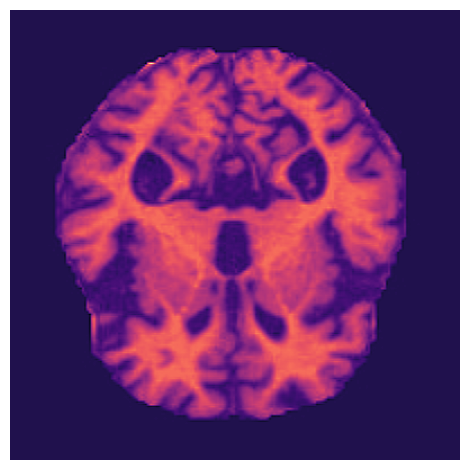

In [7]:
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)
conv_fn = tf.nn.conv2d
image_filter = conv_fn(
    input=image,
    filters=kernel,
    strides=1, # or (1, 1)
    padding='SAME',
)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_filter)
)
plt.axis('off')
plt.show();

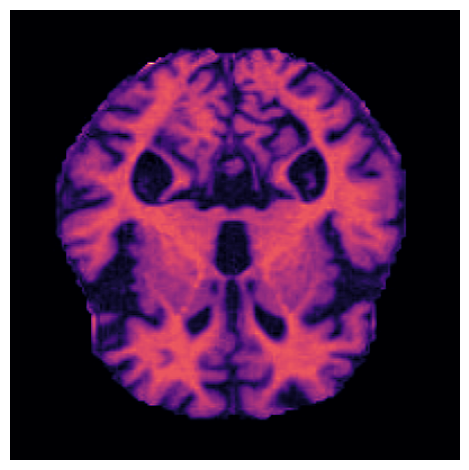

In [8]:
relu_fn = tf.nn.relu
image_detect = relu_fn(image_filter)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect)
)
plt.axis('off')
plt.show();

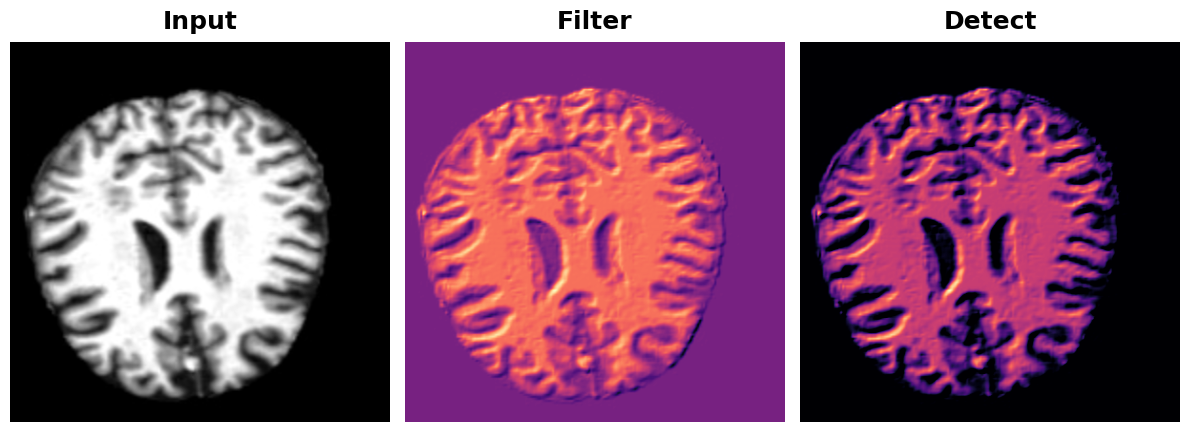

In [9]:
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex3 import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import learntools.computer_vision.visiontools as visiontools

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
image_path = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented/0001b959-d622-4311-acab-84633370c892.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Embossing kernel
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

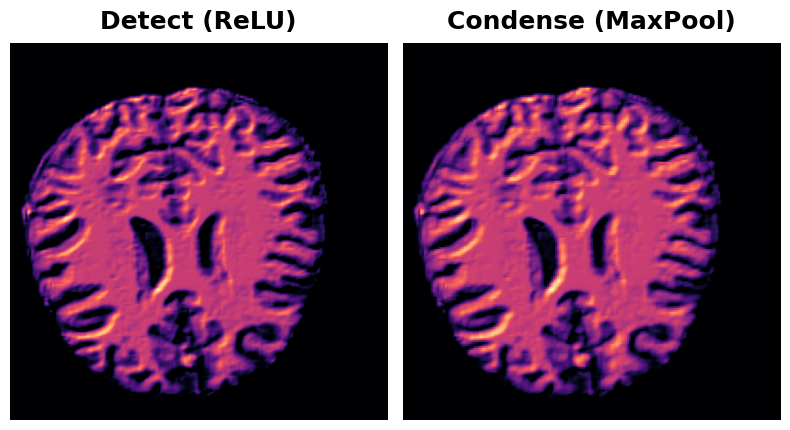

In [10]:
image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=(2, 2),
    pooling_type='MAX',
    strides=(2, 2),
    padding='SAME',
)
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

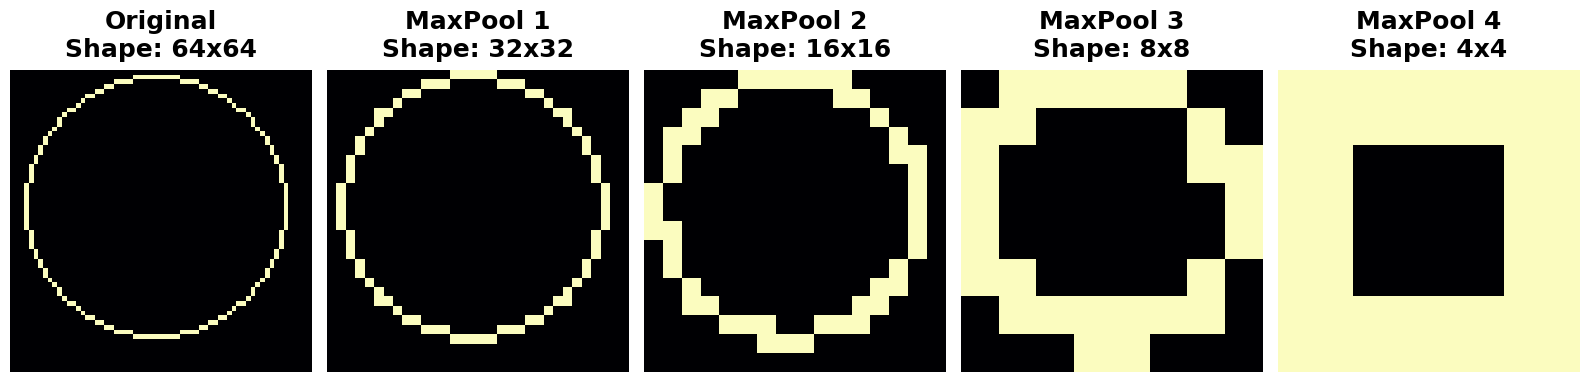

In [11]:
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = visiontools.circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = visiontools.random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

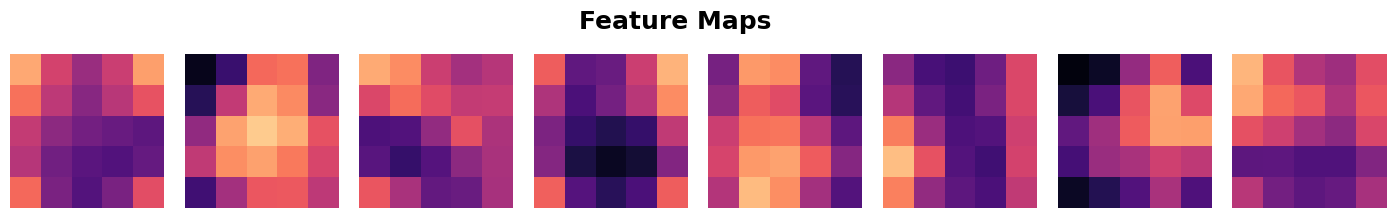

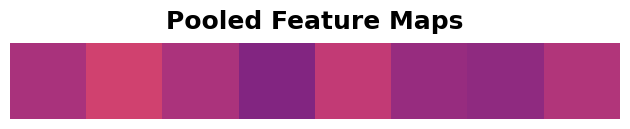

In [12]:
feature_maps = [visiontools.random_map([5, 5], scale=0.1, decay_power=3) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# reformat for TensorFlow
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1])
                   for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:,:,0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show();

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

model = keras.Sequential([
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# Load dataset
ds = image_dataset_from_directory(
    '/kaggle/input/augmented-alzheimer-mri-dataset',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

Found 40384 files belonging to 2 classes.


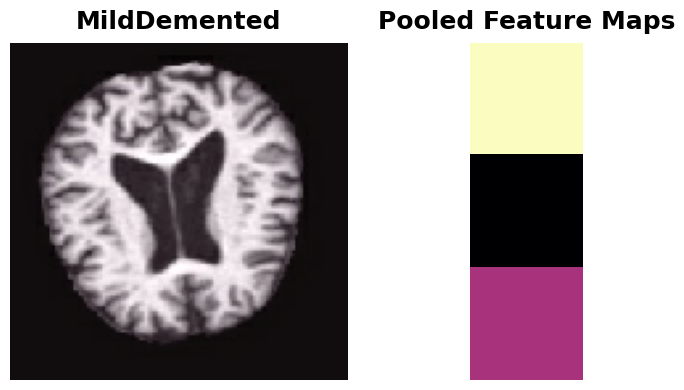

In [23]:
milddemented = next(ds_iter)

milddemented_tf = tf.image.resize(milddemented[0], size=[128, 128])
milddemented_features = model(milddemented_tf)
milddemented_features = tf.reshape(milddemented_features, shape=(3, 1))
label = int(tf.squeeze(milddemented[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(milddemented[0]))
plt.axis('off')
plt.title(["MildDemented", "ModerateDemented","NonDemented","VeryMildDemented"][label])
plt.subplot(122)
plt.imshow(milddemented_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show();